STEP1

In [1]:
import cv2
import os
import random
import numpy as np
import uuid

In [2]:
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Flatten, Input
import tensorflow as tf

STEP 2

In [3]:
POS_Path=os.path.join('data','Positive')
NEG_Path=os.path.join('data','Negative')
ANC_Path=os.path.join('data','Anchor')
# train_path=os.path('training_checkpoints')

In [ ]:
os.makedirs(POS_Path)
os.makedirs(NEG_Path)
os.makedirs(ANC_Path)
# os.makedirs(train_path)

In [ ]:
!tar -xf lfw.tgz

In [4]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_Path=os.path.join('lfw',directory,file)
        NEW_Path=os.path.join(NEG_Path,file)
        os.replace(EX_Path,NEW_Path)


STEP 3

In [5]:
cam=cv2.VideoCapture(0)
while True:
    ret,frame=cam.read()
    frames = frame[120:120+250,200:200+250,:3]
    if cv2.waitKey(1) & 0xff==ord('a'):
        imgname=os.path.join(ANC_Path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frames)

    if cv2.waitKey(1) & 0xff==ord('c'): 
        img_name=os.path.join(POS_Path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name,frames)   
    cv2.imshow('Image Collection',frames)

    if cv2.waitKey(1) & 0xff==27:
        break

cam.release()
cv2.destroyAllWindows()     

STEP 4

In [6]:
anchor=tf.data.Dataset.list_files(ANC_Path+'\*.jpg').take(30)
positive=tf.data.Dataset.list_files(POS_Path+'\*.jpg').take(30)
negative=tf.data.Dataset.list_files(NEG_Path+'\*.jpg').take(30)

In [7]:
dir_test=anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\Anchor\\b038b5e7-6cec-11ed-ae6c-0c9a3c581f00.jpg'


In [11]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(105,105))
    img=img/250
    return img

In [12]:
img= preprocess('data\\Anchor\\6acab40f-6cec-11ed-9a23-0c9a3c581f00.jpg')
img

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.35210204, 0.6964852 , 0.92714965],
        [0.3802517 , 0.71388435, 0.9752109 ],
        [0.2695578 , 0.61620176, 0.8878435 ],
        ...,
        [0.5006667 , 0.9206667 , 1.0086666 ],
        [0.49105445, 0.90734017, 1.0064831 ],
        [0.4867619 , 0.9107619 , 1.0067619 ]],

       [[0.20290478, 0.5634762 , 0.8160476 ],
        [0.36173472, 0.7077143 , 0.99944896],
        [0.14263944, 0.50568706, 0.8068911 ],
        ...,
        [0.495653  , 0.9102245 , 0.99990475],
        [0.5003061 , 0.9168571 , 1.0152041 ],
        [0.48      , 0.9037143 , 0.9991429 ]],

       [[0.2839048 , 0.66352385, 0.9140953 ],
        [0.3325374 , 0.7048232 , 0.98345584],
        [0.10939229, 0.49438322, 0.79202044],
        ...,
        [0.51257366, 0.9296009 , 1.0157914 ],
        [0.5063809 , 0.92638093, 1.0142517 ],
        [0.48361903, 0.903619  , 0.991619  ]],

       ...,

       [[0.04572567, 0.12172567, 0.18183225],
        [0.06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


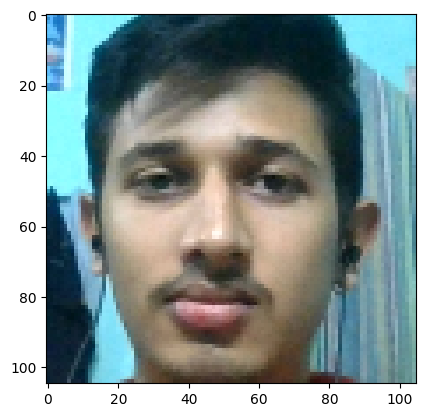

In [13]:
plt.imshow(img)

In [14]:
img.numpy().max()

1.02

In [15]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [16]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [17]:
def preprocess_twin(input_img,valid_img,label):
    return (preprocess(input_img),preprocess(valid_img),label)

In [18]:
samples=data.as_numpy_iterator()
example=samples.next()
res=preprocess_twin(*example)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


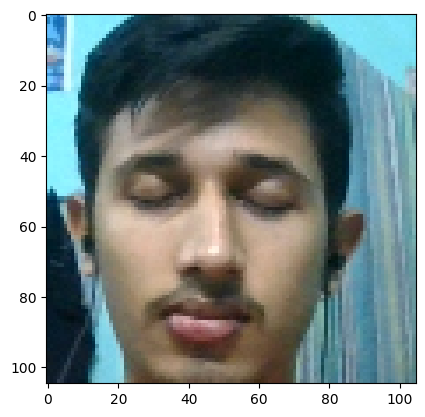

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

In [21]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [22]:
round(len(data)*.3)

18

In [23]:
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [99]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [24]:
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [101]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

STEP 4

In [25]:
inp=Input(shape=(105,105,3),name='input_image')
c1=Conv2D(64,(10,10),activation='relu')(inp)
m1=MaxPooling2D(64,(2,2),padding='same')(c1)

In [26]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [27]:
c2=Conv2D(128,(7,7),activation='relu')(m1)
m2=MaxPooling2D(64,(2,2),padding='same')(c2)

In [105]:
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_6')>

In [106]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_5')>

In [28]:
c3=Conv2D(128,(4,4),activation='relu')(m2)
m3=MaxPooling2D(64,(2,2),padding='same')(c3)

In [29]:
c4=Conv2D(256,(4,4),activation='relu')(m3)
f1=Flatten()(c4)
d1=Dense(4096,activation='sigmoid')(f1)

In [109]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_2')>

In [30]:
def make_embeddings():
    inp=Input(shape=(105,105,3),name='input_image')
    # First Block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    # Second Block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    # Third Block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    # Final Block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')    


In [31]:
embedding=Model(inputs=[inp],outputs=[d1],name='embedding')

In [32]:
# siamese L1 distance class
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,valid_embedding):
        return tf.math.abs(input_embedding - valid_embedding)    

In [33]:
l1=L1Dist()

In [ ]:
l1

In [34]:
def make_siamese_model():
    # anchor image inputs
    input_image = Input(name='input_img',shape=(105,105,3))
    # validation image inputs
    valid_image=Input(name='valid_img',shape=(105,105,3))

    # combine siamese distance components
    siamese_layer=L1Dist()
    siamese_layer_name='distance'
    distances=siamese_layer(embedding(input_image),embedding(valid_image))
    
    # classification layer
    classifier=Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image,valid_image],outputs=classifier,name='siameseNetwork')
    



In [35]:
siamese_model=make_siamese_model()

In [36]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 valid_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'valid_img[0][0]'] 

STEP 5

In [37]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [38]:
opt=tf.keras.optimizers.Adam(1e-4)

In [39]:
checkpoints_dir='./training_checkpoints'
checkpoints_prefix=os.path.join(checkpoints_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [40]:
test_batch=train_data.as_numpy_iterator()

In [41]:
batch_1=test_batch.next()

In [42]:
x=batch_1[:2]

In [43]:
y=batch_1[2]

In [44]:
tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive image
        x=batch[:2]
        # get label
        y=batch[2]

        # forward pass
        yhat=siamese_model(x,training=True)
        # calculate loss
        loss=binary_cross_loss(y,yhat)

    # calculate gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))


    return loss 

In [45]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))

        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoints_prefix)    


In [ ]:
EPOCHS=50

In [ ]:
train(train_data,EPOCHS)

In [46]:
from tensorflow.keras.metrics import Precision ,Recall

In [47]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [48]:
y_hat=siamese_model.predict([test_input,test_val])


1/1 [==============================] - 6s 6s/step


In [150]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
y_true

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [50]:
m=Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

0.7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


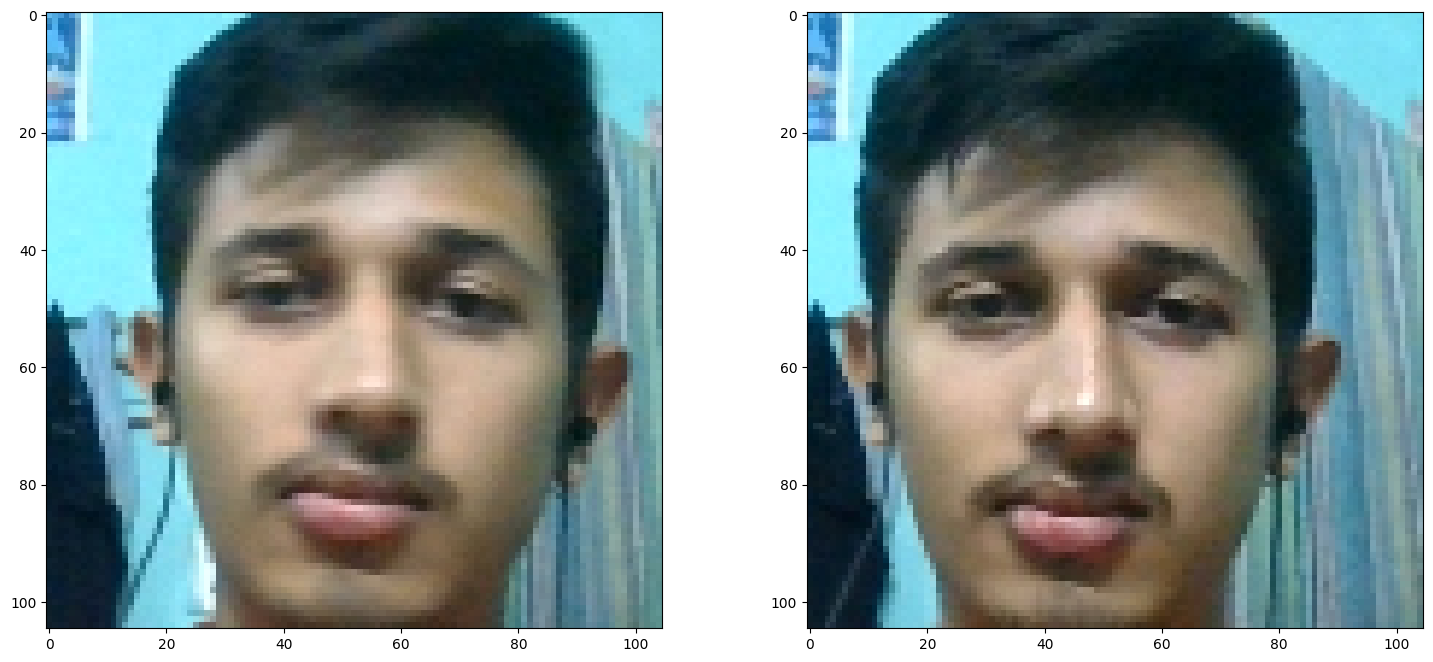

In [51]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

In [52]:
siamese_model.save('Face.h5')

In [53]:
model=tf.keras.models.load_model('Facerecog.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [54]:
model.predict([test_input,test_val])

1/1 [==============================] - 6s 6s/step


array([[0.5004284 ],
       [0.50010955],
       [0.49977   ],
       [0.49989364],
       [0.5004838 ],
       [0.49963677],
       [0.50031126],
       [0.5003141 ],
       [0.50001633],
       [0.50077575],
       [0.50182337],
       [0.50041217],
       [0.49991974],
       [0.50100774],
       [0.50014555],
       [0.50025356]], dtype=float32)

In [162]:
model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 valid_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'valid_img[0][0]'] 

In [55]:
def verify(model,detect_threshold,veri_threshold):
    results=[]
    for images in os.listdir(os.path.join('verification','ver_img')):

        input_image=preprocess(os.path.join('verification','input_image','inp_img.jpg'))
        valid_image=preprocess(os.path.join('verification','ver_img',images))
        result=model.predict(list(np.expand_dims([input_image,valid_image],axis=1)))
        results.append(result)
    detection=np.sum(np.array(results)>detect_threshold)
    verification=detection/len(os.listdir(os.path.join('verification','ver_img')))
    verified= verification > veri_threshold   
    return results, verified

In [56]:
cap=cv2.VideoCapture(0)
while True:
    ret,frame=cap.read()
    frame=frame[120:120+300,200:200+300,:]
    cv2.imshow('verification',frame)
    if cv2.waitKey(1) & 0xff==ord('v'):
        cv2.imwrite(os.path.join('verification','input_image','inp_img.jpg'),frame)
        results,verified = verify(model,0.6,0.8)
        print(verified)
    if cv2.waitKey(1) & 0xff==27:
        break
cap.release()
cv2.destroyAllWindows()  

1/1 [==============================] - 1s 568ms/step
False


In [57]:
np.sum(np.squeeze(results) >0.8)

0